In [156]:
%matplotlib inline
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import outlier_removal as out
from sklearn import linear_model


## self defined functions:
### correlated columns
To find, for a given column, another column with the highest possible correlation

In [157]:
def find_cor(name,df):
    cor=df.corr()
    index=df.columns.get_loc(name)
    if(index>2):#Dates fall out, to be corrected when we have dates
        index=index-3
    cor=cor[name]
    c=[np.abs(e) for e in cor]
    c[index]=0 # highsest correltion is with it self
    max_cor=np.max(c)
    print(max_cor)
    max_cor_index=c.index(max_cor)
    if( max_cor_index>2):
        max_cor_index=max_cor_index+3 # Dates fall out, calculate dataframe index
    max_cor_name=df.columns[max_cor_index]
    print(max_cor_name)
    return max_cor_name

### Linear 1D fit

In [158]:
def lin_regr(namex,namey):
    model = linear_model.LinearRegression()
    nansx= np.array(np.isnan(df[namex]))
    nansy= np.array(np.isnan(df[namey]))
    nan=np.logical_or(nansx,nansy)
    df_nonans=df[np.logical_not(nan)]
    x=df_nonans[namex].values
    x=[e for e in x]
    x=np.array(x)
    y=df_nonans[namey].values
    y=[e for e in y]
    y=np.array(y)
    model.fit(x[:, np.newaxis], y)
    res= model.coef_
    print("we estimate y= ax+b, with a equals:"+ str(res))
    return res

### Outliers and visualization

In [159]:
def vis_and_return_Outl(df,column,factor_iqr,a=-6,b=6,delta=0.5):
    bins2=np.arange(a,b,delta)
    df.boxplot(column,return_type='dict',whis=factor_iqr)
    plt.title('outliers')
    y=df[column]
    x=range(1, len(y)+1)
   # plt.figure()
    #plt.title(column+ " plottet against random")
    #plt.plot(x,y,'.')
    
    plt.figure()
    plt.hist(df.dropna()[column],bins=bins2,normed=True,color='g')
    plt.xlabel(column)
    
   
    plt.figure()
    f, axarr = plt.subplots(ncols=2)
    f.set_figwidth(15)
    axarr[0].scatter(df[column],df['GasCum360'],s=6,color='r')
    axarr[0].set_title("GasCum360")
    axarr[0].set_xlabel(column)
    axarr[1].scatter(df[column],df['OilCum360'],color='black',s=6)
    axarr[1].set_xlabel(column)
    axarr[1].set_title("OilCum360")
    
    #quartiles
    Q1=np.percentile(df.dropna()[column],25)
    Q3=np.percentile(df.dropna()[column],75)
    iqr=Q3-Q1
    
    #identify outliers
    mean=np.mean(df[column])
    index=np.logical_or(df[column]< Q1 - factor_iqr*iqr, df[column]> Q3 + factor_iqr*iqr)
    outliers=df[index]
    
    # plot with target variables
    
    return outliers
    

# The Actual Data Cleaning


In [160]:
df=pd.read_csv('TrainSample.csv',sep=';' )

The features that are treated in the follwoing script are in feature_group2 ( Def. See Global Analysis of missing values).
We select only those 363 lines ( row_group1), that do not have all the 18 columns belonging to feature group2 missing.

In [161]:
df=df[~ np.logical_and(np.isnan(df['Shot_Total']), np.isnan(df['Frac_Gradient (PSI/ft)'])  )] ## remove 97 lines with 18 missing
len(df)


363

## ShutInPressure_Fil (KPa) and ShutInPressure_Initial
We treat these 2 features together as they have high correlation. We can use the latter for imputation
Also we want to remove the outliers before, so they do not influence the imputation and they can be estimated together with the missing values.


### Outliers ....Fil
we use our customzied function vis_and return Outl

,API,Surf_X,Surf_Y,Date_Drilling,Date_Completion,Date_Production,Lateral_Length (ft),Depth_TVD_PPLS (ft),Erosion_PPLS (ft),Pressure_PPLS (PSI),...,Min_Rate_Slurry (bpm),ShutInPressure_Fil (KPa),ShutInPressure_Initial (KPa),ISIP (KPa),Shot_Density (shots/ft),Shot_Total,Proppant_per_ft (kg/ft),Stage_Spacing (ft),GasCum360,OilCum360
298,169,-0.361700,0.934645,13/02/2014,24/08/2014,21/10/2014,-0.098057,-1.130276,-0.687802,-0.481296,...,0.277007,3.052486,0.936939,0.349276,1.627854,0.181738,0.115375,-0.177129,1.518204,-0.170041
340,456,0.280183,-0.135503,12/05/2013,27/10/2013,20/12/2013,1.483162,-0.176755,-0.829416,0.404333,...,0.186816,-6.253073,1.056170,0.858999,-0.988721,0.591386,-0.761109,-0.152933,1.153736,-0.419644


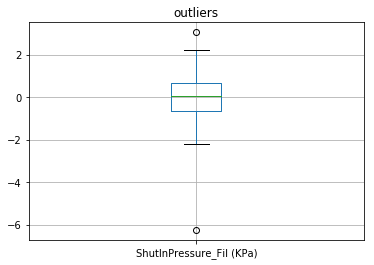

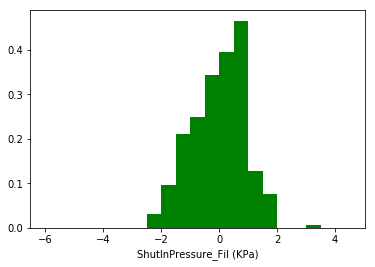

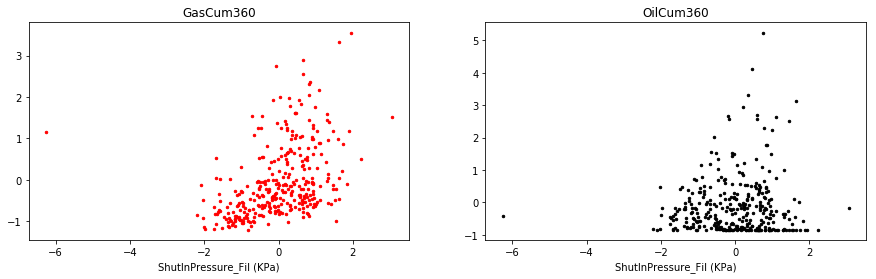

In [162]:
outs_Fil=vis_and_return_Outl(df,"ShutInPressure_Fil (KPa)",1.5,a=-6,b=5)
outs_Fil

We delete the  outliers (API =169 and 456 ). 

In [163]:
rows=outs_Fil.index
df.loc[rows,'ShutInPressure_Fil (KPa)']=np.nan
df.loc[rows,'ShutInPressure_Fil (KPa)']# to verify the removal

298   NaN
340   NaN
Name: ShutInPressure_Fil (KPa), dtype: float64

### Outliers  Shut.....Inital



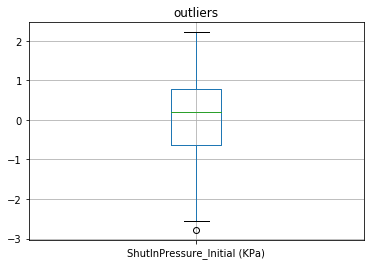

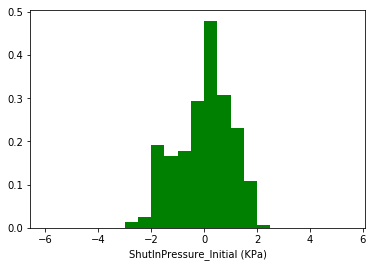

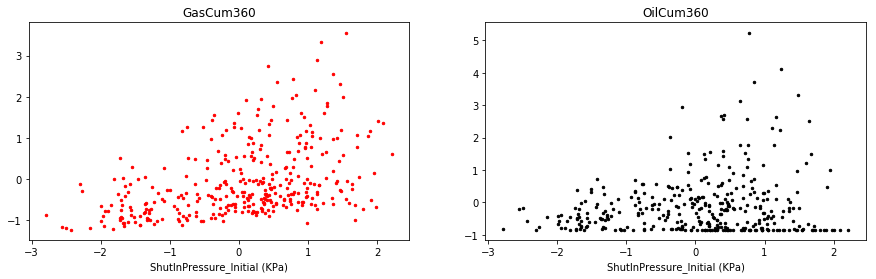

In [164]:
outs_Initial=vis_and_return_Outl(df,"ShutInPressure_Initial (KPa)",1.5)


using the histogram, we decide not to change the small outlier.

### Replace Missing Values

In [165]:
missing_Fil= np.isnan(df['ShutInPressure_Fil (KPa)'])
print('missing Fil:     '+  str(sum(missing_Fil)))
missing_Init= np.isnan(df['ShutInPressure_Initial (KPa)'])
print('missing Initial:  '+ str(sum(missing_Init)))
missing_both=np.logical_and(missing_Fil,missing_Init)
print('missing both:     '+ str(sum(missing_both)))
no_missing=np.logical_not(missing_both)
no_missing_Fil=np.logical_not(missing_Fil)
no_missing_Init=np.logical_not(missing_Init)
only_Fil_missing=np.logical_and(missing_Fil,no_missing_Init)
only_Init_missing=np.logical_and(missing_Init,no_missing_Fil)
cor=df[['ShutInPressure_Initial (KPa)','ShutInPressure_Fil (KPa)']].corr()
print('correlation     ' + str(cor.iloc[0,1]))
#df['ShutInPressure_Fil (KPa)'][missing_Fil]

missing Fil:     33
missing Initial:  6
missing both:     1
correlation     0.786873117403


### Estimate missing vals of ShutIn...Fil
As there is a high correlation between the two variables, we can  use linear regression to estimate the  values that are not mising in both features. 

The line in which both of them are missing has to be estimated by the means.

Linear fit with our customzed function:

In [166]:
a=lin_regr(find_cor('ShutInPressure_Fil (KPa)',df),'ShutInPressure_Fil (KPa)')
m1=np.mean(df['ShutInPressure_Initial (KPa)'])
m2=np.mean(df['ShutInPressure_Fil (KPa)'])
rows_Fil=df[only_Fil_missing].index
rows_both=df[missing_both].index
df.loc[rows_Fil,'ShutInPressure_Fil (KPa)']=(df['ShutInPressure_Initial (KPa)'][only_Fil_missing]- m1)*a+ m2
df.loc[rows_both,'ShutInPressure_Fil (KPa)']=m2
#print(len(rows_Fil))

0.786873117403
ShutInPressure_Initial (KPa)
we estimate y= ax+b, with a equals:[ 0.68360325]


now we have no more missing values. make scatter plot to check how the estimation was.

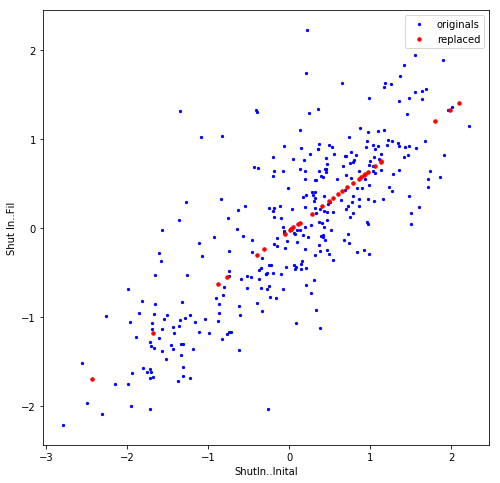

In [167]:
plt.figure(figsize=(8,8))
plt.scatter(df['ShutInPressure_Initial (KPa)'][no_missing_Fil],df['ShutInPressure_Fil (KPa)'][no_missing_Fil],color='blue',s=5,label='originals')
plt.scatter(df['ShutInPressure_Initial (KPa)'][~no_missing_Fil],df['ShutInPressure_Fil (KPa)'][~no_missing_Fil],color='red',s=12,label='replaced')
plt.xlabel('ShutIn..Inital')
plt.ylabel('Shut In..Fil')
plt.legend()



### Estimate missing vals of ShutIn...Initial


In [168]:
a=lin_regr(find_cor('ShutInPressure_Initial (KPa)',df),'ShutInPressure_Initial (KPa)')
m1=np.mean(df['ShutInPressure_Fil (KPa)'])
m2=np.mean(df['ShutInPressure_Initial (KPa)'])
rows_In=df[only_Init_missing].index
df.loc[rows_In,'ShutInPressure_Initial (KPa)']=(df['ShutInPressure_Fil (KPa)'][only_Init_missing]- m1)*a+ m2
df.loc[rows_both,'ShutInPressure_Initial (KPa)']=m2# estimate with mean

0.799457793897
ShutInPressure_Fil (KPa)
we estimate y= ax+b, with a equals:[ 0.93580418]


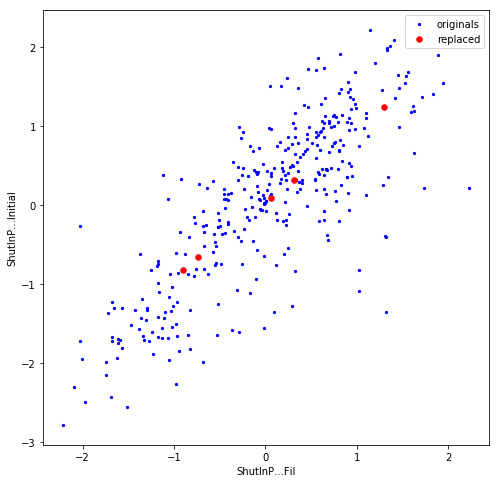

In [169]:
plt.figure(figsize=(8,8))
plt.scatter(df['ShutInPressure_Fil (KPa)'][~only_Init_missing],df['ShutInPressure_Initial (KPa)'][~only_Init_missing],color='blue',s=5,label='originals')
plt.scatter(df['ShutInPressure_Fil (KPa)'][only_Init_missing],df['ShutInPressure_Initial (KPa)'][only_Init_missing],color='red',s=30,label='replaced')
plt.ylabel('ShutInP...Initial')
plt.xlabel('ShutInP...Fil')
plt.legend()


## ISIP (KPa
"Normalized Instantaneous Shut-In Pressure (PSI), proxy to the stress in the reservoir"
# Outliers


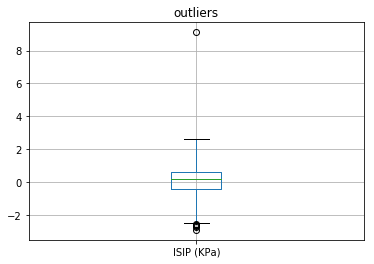

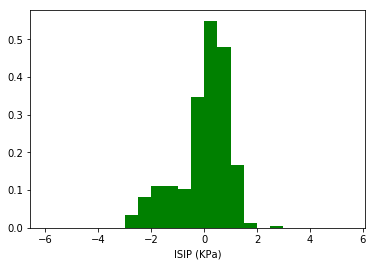

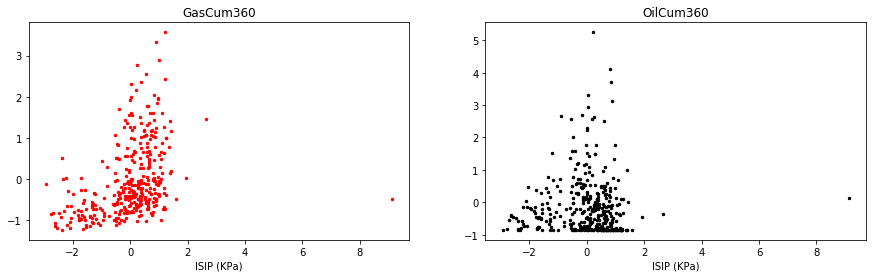

In [170]:
outs_Isip=vis_and_return_Outl(df,"ISIP (KPa)",2)
rows=df["ISIP (KPa)"][df["ISIP (KPa)"]>2].index
df.loc[rows,"ISIP (KPa)"]=np.nan # verified

The boxplot is misleading here as it seems we have two clusters of values. when the treshold 1.5 IQR is chosen, we would have plenty of outliers. Rather than using the boxplot, we use the target plot to indentify and delete the two biggest outliers.

### Replace missing values


In [171]:
missing_Isip= np.isnan(df['ISIP (KPa)'])
print('missing Isip:     '+  str(sum(missing_Isip)))
df[missing_Isip]

missing Isip:     4


,API,Surf_X,Surf_Y,Date_Drilling,Date_Completion,Date_Production,Lateral_Length (ft),Depth_TVD_PPLS (ft),Erosion_PPLS (ft),Pressure_PPLS (PSI),...,Min_Rate_Slurry (bpm),ShutInPressure_Fil (KPa),ShutInPressure_Initial (KPa),ISIP (KPa),Shot_Density (shots/ft),Shot_Total,Proppant_per_ft (kg/ft),Stage_Spacing (ft),GasCum360,OilCum360
58,553,0.126157,-0.220907,15/03/2012,29/04/2012,14/07/2012,-0.647532,0.126219,0.120175,0.447324,...,0.332100,-0.169081,-1.118669,NaN,0.667339,-0.560750,-0.305301,2.339477,-0.494240,0.117476
190,261,0.390100,-0.246404,12/05/2013,10/02/2014,12/04/2014,-1.174605,-0.097463,-1.162731,0.021191,...,0.274975,0.382667,0.600586,NaN,-1.253690,0.181738,-0.456037,-0.227539,-0.399198,-0.661032
260,562,-0.290266,0.913680,24/12/2014,09/01/2016,22/04/2016,3.164569,-1.171615,-0.643050,-0.473676,...,-0.158848,1.308340,-0.394111,NaN,0.667339,-0.560750,-0.639881,-0.105355,1.448017,-0.368460
438,83,0.444653,-0.553453,24/02/2012,27/04/2012,10/07/2012,-0.539877,0.377543,-1.217313,0.367718,...,-0.621647,-0.626338,-0.875424,NaN,-0.293176,-1.303237,-0.137177,1.593895,-0.436901,-0.081575


In [172]:
find_cor('ISIP (KPa)',df)

0.854414576898
ShutInPressure_Fil (KPa)


'ShutInPressure_Fil (KPa)'

As ShutInPressure_Fil (KPa) has missing values or outliers in the same columns, we check the correlation with 
ShutIn..Inital which is  0.63  ( not shown here.
Luckily ShutInP....Fil did not have missing vals in the same columns. So we can use it to estimate the two missing vals:

we estimate y= ax+b, with a equals:[ 0.69772658]


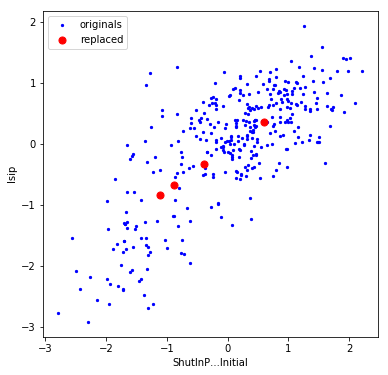

In [173]:
a3=lin_regr('ShutInPressure_Initial (KPa)','ISIP (KPa)')
m1=np.mean(df['ShutInPressure_Initial (KPa)'])
m2=np.mean(df['ISIP (KPa)'])
rows=df['ISIP (KPa)'][missing_Isip].index
df.loc[rows,'ISIP (KPa)']=(df['ShutInPressure_Initial (KPa)'][missing_Isip]- m1)*a3+ m2

plt.figure(figsize=(6,6))
plt.scatter(df['ShutInPressure_Initial (KPa)'][~missing_Isip],df['ISIP (KPa)'][~missing_Isip],color='blue',s=5,label='originals')
plt.scatter(df['ShutInPressure_Initial (KPa)'][missing_Isip],df['ISIP (KPa)'][missing_Isip],color='red',s=50,label='replaced')
plt.xlabel('ShutInP...Initial')
plt.ylabel('Isip')
plt.legend()



# Shot_Density (shots/ft)
<< *Normalized Total number of shots in the well per feet (shots/ft)*>>
 
It looks like we have a discrete variable here. We do not see a outlier on the second plot either.
We notice that the variable has two big 'centers' of distribution.

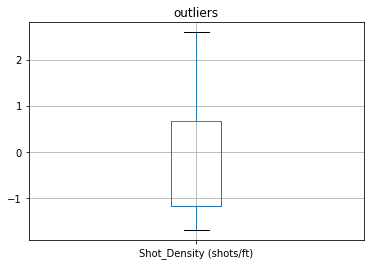

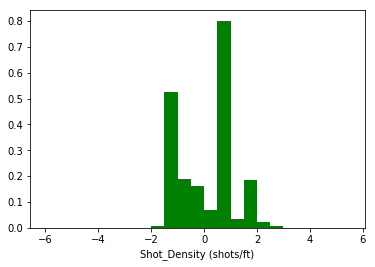

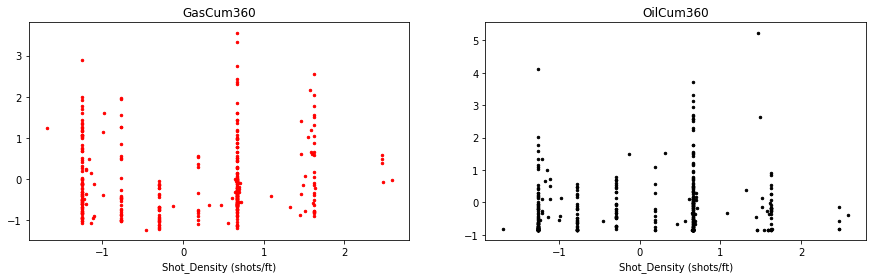

In [174]:
outs_SD=vis_and_return_Outl(df,"Shot_Density (shots/ft)",1.5)

In [175]:
z=df['Shot_Density (shots/ft)']
unique_vals=list(z.unique())
#u=[unique_vals.index(e) for e in z]
len(unique_vals)

59

As we have 59 different values, we assume that Shot_Density is just a discrete numerical value( for ex a discretized integeger).

In [176]:
missing_SD= np.isnan(df['Shot_Density (shots/ft)'])
print('missing SD:     '+  str(sum(missing_SD)))
df[missing_SD]


missing SD:     1


,API,Surf_X,Surf_Y,Date_Drilling,Date_Completion,Date_Production,Lateral_Length (ft),Depth_TVD_PPLS (ft),Erosion_PPLS (ft),Pressure_PPLS (PSI),...,Min_Rate_Slurry (bpm),ShutInPressure_Fil (KPa),ShutInPressure_Initial (KPa),ISIP (KPa),Shot_Density (shots/ft),Shot_Total,Proppant_per_ft (kg/ft),Stage_Spacing (ft),GasCum360,OilCum360
131,452,1.217796,-0.884183,13/01/2012,15/03/2012,22/06/2012,-1.394893,0.236538,1.769934,-2.259171,...,0.80519,-1.229073,-1.892207,-1.717553,NaN,-1.303237,-0.295429,2.260683,-0.774324,-0.786149


As the highest correlation with another variable is 0.33 and we have only one missing value we just replace by median.

In [177]:
df.loc[missing_SD,'Shot_Density (shots/ft)']=np.median(df['Shot_Density (shots/ft)']) # verified
df[missing_SD]


/home/andreas/.local/lib/python3.5/site-packages/numpy/lib/function_base.py:4016: RuntimeWarning: Invalid value encountered in median
  r = func(a, **kwargs)


,API,Surf_X,Surf_Y,Date_Drilling,Date_Completion,Date_Production,Lateral_Length (ft),Depth_TVD_PPLS (ft),Erosion_PPLS (ft),Pressure_PPLS (PSI),...,Min_Rate_Slurry (bpm),ShutInPressure_Fil (KPa),ShutInPressure_Initial (KPa),ISIP (KPa),Shot_Density (shots/ft),Shot_Total,Proppant_per_ft (kg/ft),Stage_Spacing (ft),GasCum360,OilCum360
131,452,1.217796,-0.884183,13/01/2012,15/03/2012,22/06/2012,-1.394893,0.236538,1.769934,-2.259171,...,0.80519,-1.229073,-1.892207,-1.717553,NaN,-1.303237,-0.295429,2.260683,-0.774324,-0.786149


# Shot_Total
*<< Normalized Total number of shots in the well >>*
wikipedia:
*Oil well shooting is a method of increasing production of an oil well by removing obstructions to drilling, straightening crooked holes, preventing water penetration, and/or increase the flow of oil*

As the variable is a normalized integer, we expect discrete values.
We notice the same behavior as for Shot_Density.



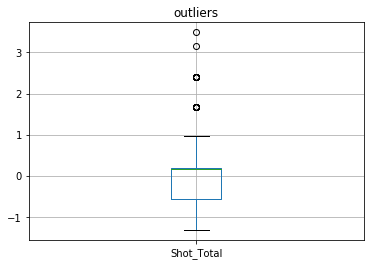

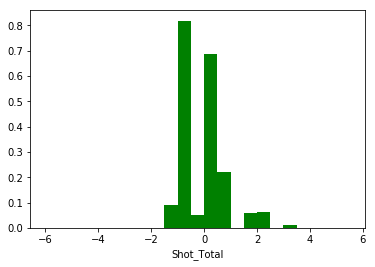

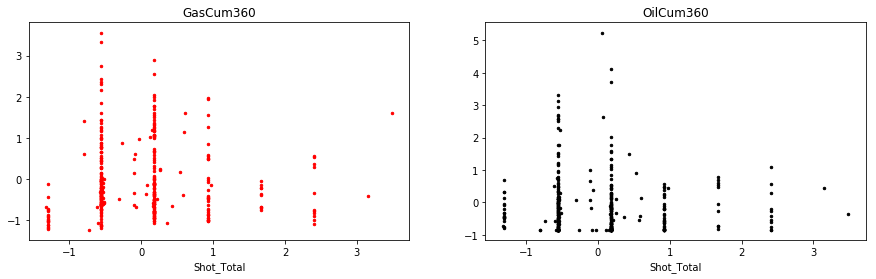

In [178]:
outs_ST=vis_and_return_Outl(df,"Shot_Total",1.5)

We replace the two highest outliers with max value that the variable has when they are left out.

In [179]:
max=np.max(df['Shot_Total'][df['Shot_Total']<3])
r_ind=df[df['Shot_Total']>3].index
df.loc[r_ind,'Shot_Total']=max


### Missing Values
we have one missing value

In [180]:
missing_ST= np.isnan(df['Shot_Total'])
print('missing SD:     '+  str(sum(missing_ST)))
df[missing_ST]

missing SD:     1


,API,Surf_X,Surf_Y,Date_Drilling,Date_Completion,Date_Production,Lateral_Length (ft),Depth_TVD_PPLS (ft),Erosion_PPLS (ft),Pressure_PPLS (PSI),...,Min_Rate_Slurry (bpm),ShutInPressure_Fil (KPa),ShutInPressure_Initial (KPa),ISIP (KPa),Shot_Density (shots/ft),Shot_Total,Proppant_per_ft (kg/ft),Stage_Spacing (ft),GasCum360,OilCum360
259,670,-0.41916,-0.114792,27/11/2013,03/06/2014,05/08/2014,0.24731,0.526063,0.884547,-0.8916,...,0.467576,-0.517849,-0.107408,-1.206691,0.318061,NaN,0.466094,0.03767,-0.62725,1.536103


In [181]:
find_cor('Shot_Total',df) 

0.251079182789
Shot_Density (shots/ft)


'Shot_Density (shots/ft)'

As we could not find highly correlated columns, we replace the missing value with the mean.

In [182]:
df.loc[259,'Shot_Total']=np.mean(df['Shot_Total']) 


# Proppant_per_ft
*Normalized Weight of proppant pumped during completion normalzied per feet (kg/ft)*

It looks we have two clusters again, but this time the first cluster is a lot bigger.


## Outliers


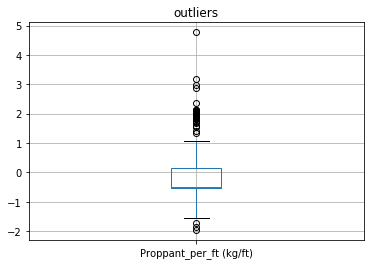

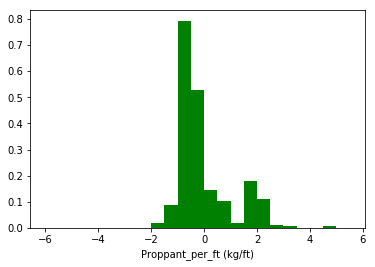

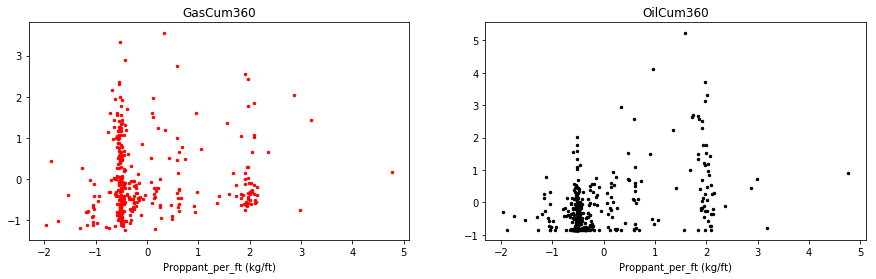

In [183]:
outs_Propp=vis_and_return_Outl(df,"Proppant_per_ft (kg/ft)",1.5)

Looking at the histogram, we decide to change the outlying values > 4 to a less extreme value.

In [184]:
rows=df[df["Proppant_per_ft (kg/ft)"]>4].index
df.loc[rows,"Proppant_per_ft (kg/ft)"]=3

## Missing Values

In [185]:
missing_Prop=np.isnan(df["Proppant_per_ft (kg/ft)"]) # 1 value
find_cor('Proppant_per_ft (kg/ft)',df)

0.805843641482
Proppant_in_Formation (kg)


'Proppant_in_Formation (kg)'

we have found a highly correlated column. Unfortunately we have a missing value in the same row.
Luckily Proppant_Designed is also very correlated (cor = 0.8) and does not have missing vals in the same row.

In [186]:
a3=lin_regr('Proppant_Designed (kg)','Proppant_per_ft (kg/ft)')
m1=np.mean(df['Proppant_Designed (kg)'])
m2=np.mean(df['Proppant_Designed (kg)'])
rows=df['Proppant_per_ft (kg/ft)'][missing_Prop].index
df.loc[rows,'Proppant_per_ft (kg/ft)']=(df['Proppant_Designed (kg)'][missing_Prop]- m1)*a3+ m2

we estimate y= ax+b, with a equals:[ 0.7755579]


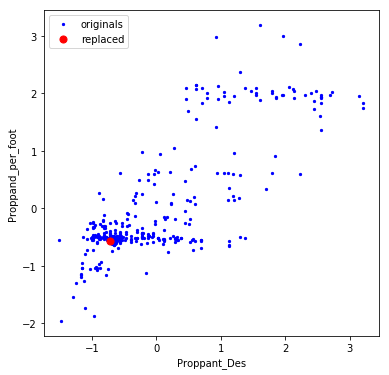

In [187]:
plt.figure(figsize=(6,6))
plt.scatter(df['Proppant_Designed (kg)'][~missing_Prop],df['Proppant_per_ft (kg/ft)'][~missing_Prop],color='blue',s=5,label='originals')
plt.scatter(df['Proppant_Designed (kg)'][missing_Prop],df['Proppant_per_ft (kg/ft)'][missing_Prop],color='red',s=50,label='replaced')
plt.xlabel('Proppant_Des')
plt.ylabel('Proppand_per_foot')
plt.legend()

# Stage_Spacing (ft) 
we can see a high linear ( or hyperbolic) correlation with OilCum. A little bit less , but still high correlation with GasCum.


## Outliers
we replace one huge outliers by the mean. The other outliers carry important information about the target variables.


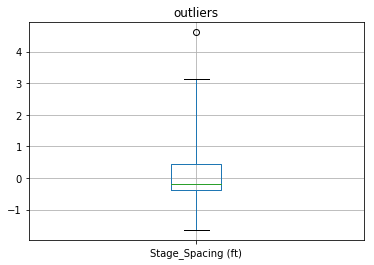

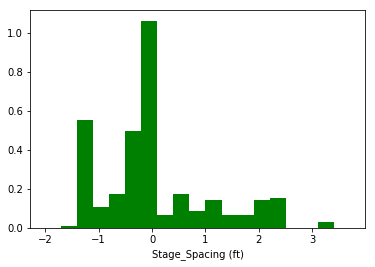

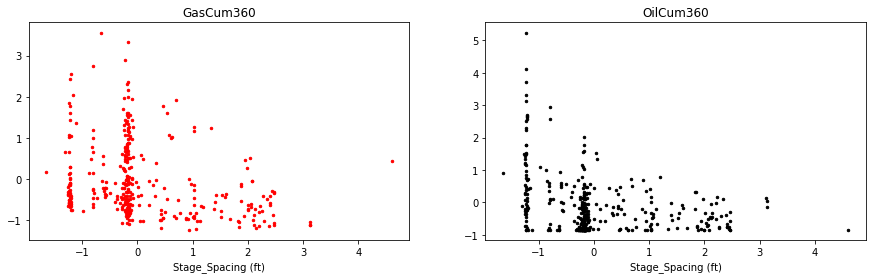

In [188]:
outs_StS=vis_and_return_Outl(df,"Stage_Spacing (ft)",4,delta=0.3,a=-2,b=4)



In [189]:
rows=outs_StS.index
df.loc[rows,"Stage_Spacing (ft)"]=np.mean(df['Stage_Spacing (ft)'])

# Avg_Breakdown_Pressure (KPa)

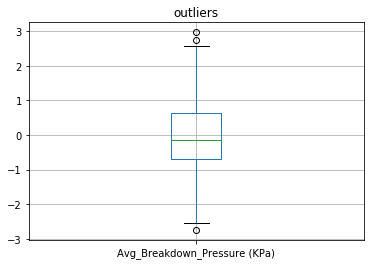

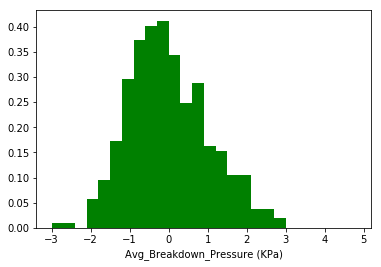

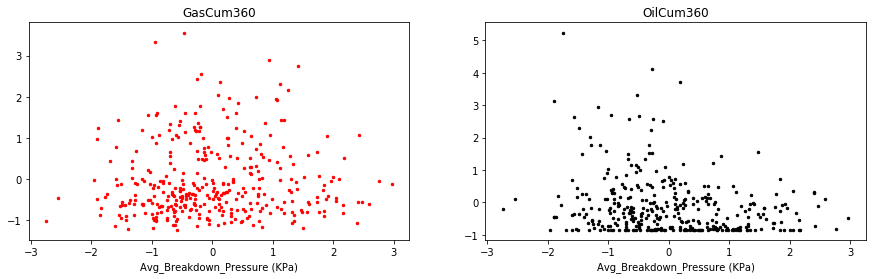

In [190]:
outs_Abp=vis_and_return_Outl(df,'Avg_Breakdown_Pressure (KPa)',1.5,delta=0.3,a=-3,b=5)



We  do not see huge outliers.

## Missing Values

In [191]:
missing_Abp=np.isnan(df["Avg_Breakdown_Pressure (KPa)"]) # 1 value
df[missing_Abp] # two missing values


,API,Surf_X,Surf_Y,Date_Drilling,Date_Completion,Date_Production,Lateral_Length (ft),Depth_TVD_PPLS (ft),Erosion_PPLS (ft),Pressure_PPLS (PSI),...,Min_Rate_Slurry (bpm),ShutInPressure_Fil (KPa),ShutInPressure_Initial (KPa),ISIP (KPa),Shot_Density (shots/ft),Shot_Total,Proppant_per_ft (kg/ft),Stage_Spacing (ft),GasCum360,OilCum360
437,63,0.031635,-0.029018,04/09/2012,14/12/2012,23/06/2013,-0.583437,-0.099078,0.623752,-0.009573,...,0.440142,0.552988,0.588143,0.978815,-0.293176,0.970631,-0.551515,0.278012,-0.143814,0.429637
458,381,0.539683,-0.054399,23/10/2011,15/03/2012,22/06/2012,-0.633220,-0.522279,-1.239967,0.250447,...,0.585440,-0.851824,-1.649836,-0.797323,0.667339,-0.560750,-0.262110,1.875340,-0.158165,-0.724854


As there is no other variable with high correlation, we just replace missing values by mean.

In [192]:
rows=df[missing_Abp].index
df.loc[rows,'Avg_Breakdown_Pressure (KPa)']=np.mean(df['Avg_Breakdown_Pressure (KPa)'])


# Avg/Min/Max_Treating_Pressure (KPa)
we treat this variables together  as they are highly correlated.

cor(Avg,Min) =0.7

cor(Avg,Max) =0.5

cor(Min,Max) =0.4

### Outliers Avg treating pressure

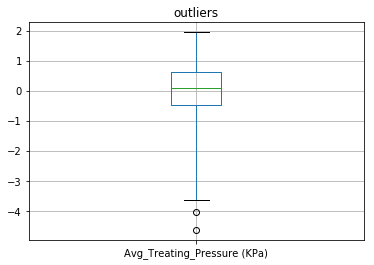

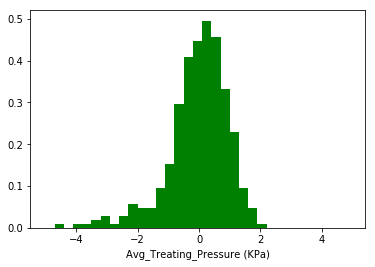

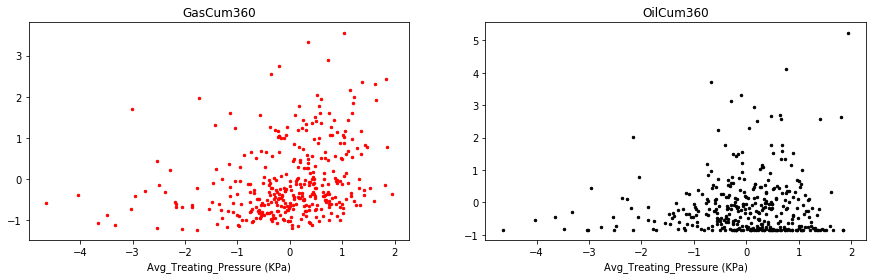

In [193]:
outs_Atp=vis_and_return_Outl(df,'Avg_Treating_Pressure (KPa)',3,delta=0.3,a=-5,b=5)#
#df.corr()['Avg_Treating_Pressure (KPa)'].sort_values()#,'Avg_Treating_Pressure (KPa)','Max_Treating_pressure (KPa)']
#df.corr()['Max_Treating_pressure (KPa)'].sort_values()#,'Avg_Treating_Pressure (KPa)','Max_Treating_pressure (KPa)']

To the left side of the histogram, it seems that there are same outliers.
We plot against correlated variables to see more..

Text(0,0.5,'min treating pressure')

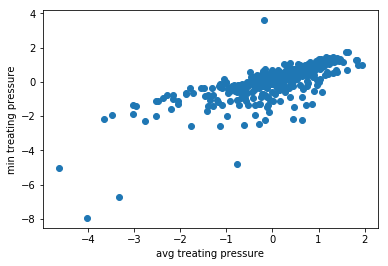

In [194]:

plt.scatter(df['Avg_Treating_Pressure (KPa)'],df['Min_Treating_Pressure (KPa)'])
plt.xlabel('avg treating pressure')
plt.ylabel('min treating pressure')

    We decided only to delete the outliers with values < - 2.5 
    

In [195]:
rows=df['Avg_Treating_Pressure (KPa)']< -2.5
df.loc[rows,'Avg_Treating_Pressure (KPa)']=np.nan


### Outliers Min treating pressure

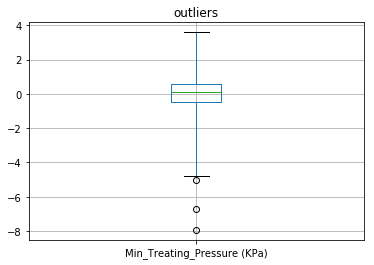

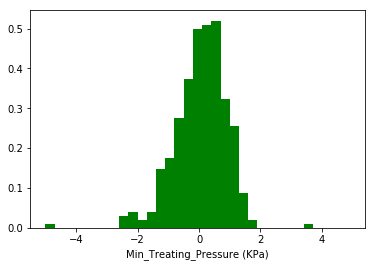

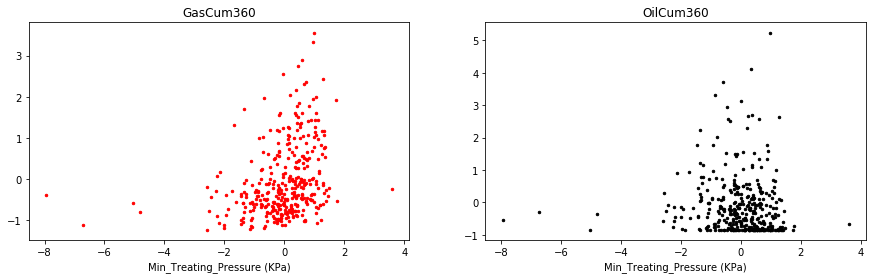

In [196]:
outs_Mitp=vis_and_return_Outl(df,'Min_Treating_Pressure (KPa)',4.1,delta=0.3,a=-5,b=5)
rows=outs_Mitp.index
df.loc[rows,'Min_Treating_Pressure (KPa)']=np.nan # delete outliers determinded by boxplot

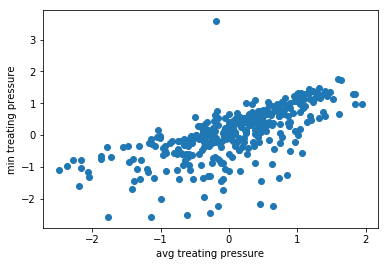

In [197]:
plt.scatter(df['Avg_Treating_Pressure (KPa)'],df['Min_Treating_Pressure (KPa)'])
plt.xlabel('avg treating pressure')
plt.ylabel('min treating pressure')
rows=df[df['Min_Treating_Pressure (KPa)'] >1.4].index
df.loc[rows,'Min_Treating_Pressure (KPa)']=0


We change the biggest outlier.

### Outliers Max treating pressure

,API,Surf_X,Surf_Y,Date_Drilling,Date_Completion,Date_Production,Lateral_Length (ft),Depth_TVD_PPLS (ft),Erosion_PPLS (ft),Pressure_PPLS (PSI),...,Min_Rate_Slurry (bpm),ShutInPressure_Fil (KPa),ShutInPressure_Initial (KPa),ISIP (KPa),Shot_Density (shots/ft),Shot_Total,Proppant_per_ft (kg/ft),Stage_Spacing (ft),GasCum360,OilCum360
45,333,0.994444,-0.744697,02/07/2013,12/01/2014,01/03/2014,-1.440320,0.206008,1.476156,-0.651776,...,0.231913,0.341291,0.540059,0.594771,-1.253690,0.181738,-0.260873,-0.318573,-0.576744,-0.838597
99,728,0.588880,-0.914507,05/07/2013,27/08/2013,13/11/2013,0.493111,0.884290,-1.556034,-0.118940,...,0.144927,0.006552,0.050392,0.129965,-1.253690,0.181738,-0.613397,-0.132048,-0.321493,0.132009
186,636,0.889209,-1.297541,28/03/2011,28/06/2011,24/07/2011,0.010220,1.167945,0.100313,0.686254,...,0.763242,0.001847,0.043509,-0.145505,0.667339,2.409201,1.409488,0.003925,-0.399839,0.451754
326,544,0.856238,-0.226241,28/07/2013,04/02/2014,26/03/2014,-0.068187,-0.498395,0.449106,1.570464,...,0.181206,0.162901,0.279104,-0.380946,-1.253690,0.181738,-0.387433,-0.260255,1.706054,-0.846812
398,110,0.946410,0.473397,30/11/2011,26/06/2012,04/04/2016,0.846567,-1.493223,0.145449,NaN,...,0.611749,-0.205570,-0.157324,-0.991352,0.667339,-0.560750,-1.871937,0.063128,0.441983,-0.846812


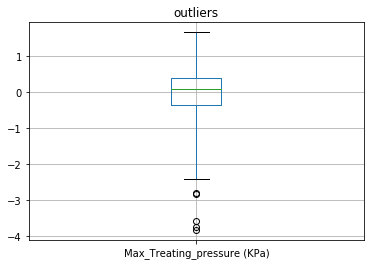

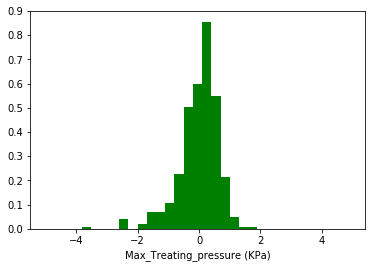

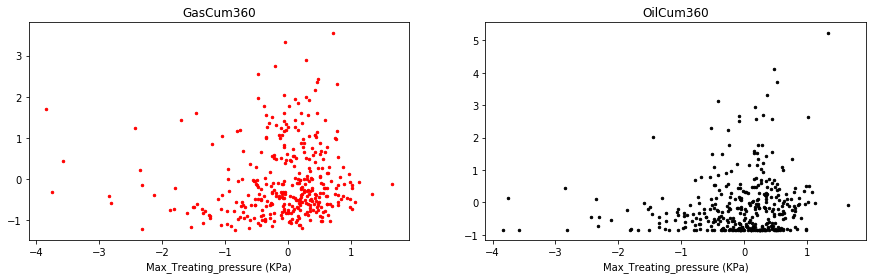

In [198]:
outs_Matp=vis_and_return_Outl(df,'Max_Treating_pressure (KPa)',3,delta=0.3,a=-5,b=5)
outs_Matp

Text(0,0.5,'max treating pressure')

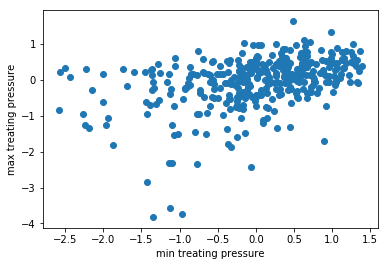

In [199]:
plt.scatter(df['Min_Treating_Pressure (KPa)'],df['Max_Treating_pressure (KPa)'])
plt.xlabel('min treating pressure')
plt.ylabel('max treating pressure')

We choose to delete outliers < 2.5  ( compare oil and gas plot)

In [200]:
rows=outs_Matp.index
df.loc[rows,'Max_Treating_pressure (KPa)']=np.nan # delete outliers determinded by boxplot
rows2=df[df['Max_Treating_pressure (KPa)']> 1.25].index
df.loc[rows2,'Max_Treating_pressure (KPa)']=np.nan # delete outliers > 1.25 ( see plot)
rows

Int64Index([45, 99, 186, 326, 398], dtype='int64')

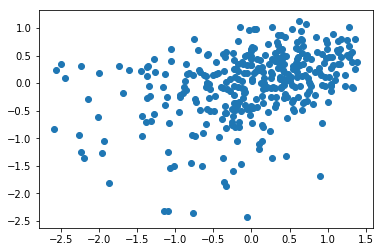

In [201]:
plt.scatter(df['Min_Treating_Pressure (KPa)'],df['Max_Treating_pressure (KPa)'])

## replace the missing values


In [202]:
missing_Atp=np.isnan(df["Avg_Treating_Pressure (KPa)"])
missing_Mitp=np.isnan(df["Min_Treating_Pressure (KPa)"])
missing_Matp=np.isnan(df["Max_Treating_pressure (KPa)"])
print(sum(missing_Atp))
print(sum(missing_Mitp))
print(sum(missing_Matp))


11
5
8


In [203]:
missing_all=np.logical_and(missing_Atp,missing_Mitp)
missing_all=np.logical_and(missing_all,missing_Matp)
print(sum(missing_all))

1


We have one value that all the three features have missing in the same row. We have to estimate it by the mean.

In [204]:
rows=df[missing_all].index
df.loc[rows,"Avg_Treating_Pressure (KPa)"]=np.mean(df['Avg_Treating_Pressure (KPa)'])
df.loc[rows,"Min_Treating_Pressure (KPa)"]=np.mean(df['Min_Treating_Pressure (KPa)'])
df.loc[rows,"Max_Treating_pressure (KPa)"]=np.mean(df['Max_Treating_pressure (KPa)'])

Estimate the rest of the missong vals each variable by another.

In [205]:
mA=np.mean(df['Avg_Treating_Pressure (KPa)'])
mMi=np.mean(df['Min_Treating_Pressure (KPa)'])
mMa=np.mean(df['Max_Treating_pressure (KPa)'])
rows_In=df[only_Init_missing].index
df.loc[rows_In,'ShutInPressure_Initial (KPa)']=(df['ShutInPressure_Fil (KPa)'][only_Init_missing]- m1)*a+ m2
df.loc[rows_both,'ShutInPressure_Initial (KPa)']=m2# estimate with mean

### Missing Avg

In [206]:
AvNotMin=np.logical_and(missing_Atp,~missing_Mitp)
print(sum(AvNotMin))
AvNotMax=np.logical_and(missing_Atp,~missing_Matp)
print(sum(AvNotMax))

8
7


In [207]:
a3=lin_regr('Max_Treating_pressure (KPa)','Avg_Treating_Pressure (KPa)')
rows=df[AvNotMax].index
df.loc[rows,'Avg_Treating_Pressure (KPa)']=(df['Max_Treating_pressure (KPa)'][AvNotMax]- mMa)*a3+ mA

we estimate y= ax+b, with a equals:[ 0.76623624]


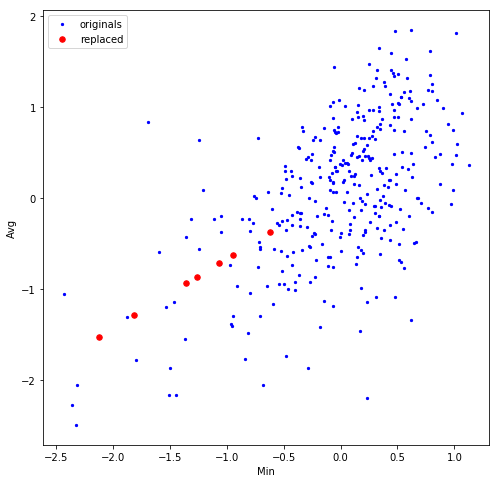

In [208]:
plt.figure(figsize=(8,8))
plt.scatter(df['Max_Treating_pressure (KPa)'][~AvNotMax],df['Avg_Treating_Pressure (KPa)'][~AvNotMax],color='blue',s=5,label='originals')
plt.scatter(df['Max_Treating_pressure (KPa)'][AvNotMax],df['Avg_Treating_Pressure (KPa)'][AvNotMax],color='red',s=30,label='replaced')
plt.ylabel('Avg')
plt.xlabel('Min')
plt.legend()


In [209]:
a3=lin_regr('Min_Treating_Pressure (KPa)','Avg_Treating_Pressure (KPa)')
rows=df[AvNotMin].index
df.loc[rows,'Avg_Treating_Pressure (KPa)']=(df['Min_Treating_Pressure (KPa)'][AvNotMin]- mMi)*a3+ mA

we estimate y= ax+b, with a equals:[ 0.65750718]


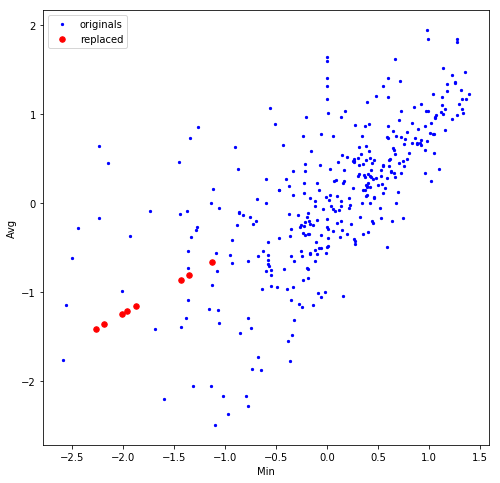

In [210]:
plt.figure(figsize=(8,8))
plt.scatter(df['Min_Treating_Pressure (KPa)'][~AvNotMin],df['Avg_Treating_Pressure (KPa)'][~AvNotMin],color='blue',s=5,label='originals')
plt.scatter(df['Min_Treating_Pressure (KPa)'][AvNotMin],df['Avg_Treating_Pressure (KPa)'][AvNotMin],color='red',s=30,label='replaced')
plt.ylabel('Avg')
plt.xlabel('Min')
plt.legend()

### Missing Min

In [211]:
MinNotAv=np.logical_and(~missing_Atp,missing_Mitp)
print(sum(MinNotAv))
MinNotMax=np.logical_and(missing_Mitp,~missing_Matp)
print(sum(MinNotMax))

2
3


In [212]:
a3=lin_regr('Max_Treating_pressure (KPa)','Min_Treating_Pressure (KPa)')
rows=df[MinNotMax].index
df.loc[rows,'Min_Treating_Pressure (KPa)']=(df['Max_Treating_pressure (KPa)'][MinNotMax]- mMa)*a3+ mMi

we estimate y= ax+b, with a equals:[ 0.50181913]


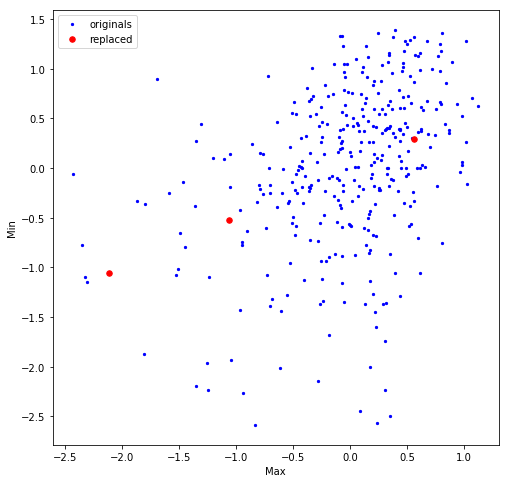

In [213]:
plt.figure(figsize=(8,8))
plt.scatter(df['Max_Treating_pressure (KPa)'][~MinNotMax],df['Min_Treating_Pressure (KPa)'][~MinNotMax],color='blue',s=5,label='originals')
plt.scatter(df['Max_Treating_pressure (KPa)'][MinNotMax],df['Min_Treating_Pressure (KPa)'][MinNotMax],color='red',s=30,label='replaced')
plt.ylabel('Min')
plt.xlabel('Max')
plt.legend()

In [214]:
a3=lin_regr('Avg_Treating_Pressure (KPa)','Min_Treating_Pressure (KPa)')
rows=df[MinNotAv].index
df.loc[rows,'Min_Treating_Pressure (KPa)']=(df['Avg_Treating_Pressure (KPa)'][MinNotAv]- mMa)*a3+ mMi

we estimate y= ax+b, with a equals:[ 0.66759479]


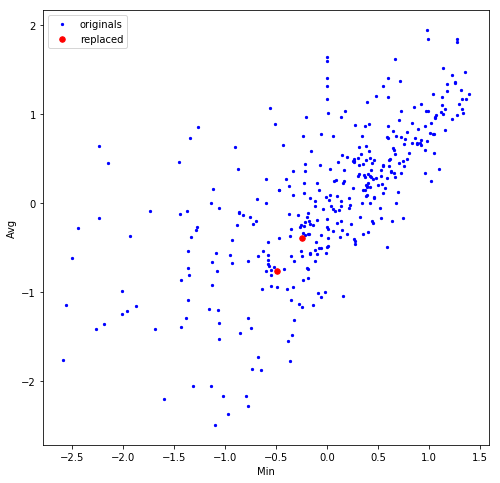

In [215]:
plt.figure(figsize=(8,8))
plt.scatter(df['Min_Treating_Pressure (KPa)'][~MinNotAv],df['Avg_Treating_Pressure (KPa)'][~MinNotAv],color='blue',s=5,label='originals')
plt.scatter(df['Min_Treating_Pressure (KPa)'][MinNotAv],df['Avg_Treating_Pressure (KPa)'][MinNotAv],color='red',s=30,label='replaced')
plt.ylabel('Avg')
plt.xlabel('Min')
plt.legend()

### Missing Max

In [216]:
MaxNotAv=np.logical_and(~missing_Atp,missing_Matp)
print(sum(MaxNotAv))
MaxNotMin=np.logical_and(~missing_Mitp,missing_Matp)
print(sum(MaxNotMin))

4
6


In [217]:
a3=lin_regr('Min_Treating_Pressure (KPa)','Max_Treating_pressure (KPa)')
rows=df[MaxNotMin].index

df.loc[rows,'Max_Treating_pressure (KPa)']=(df['Min_Treating_Pressure (KPa)'][MaxNotMin]- mMi)*a3+ mMa

we estimate y= ax+b, with a equals:[ 0.29979026]


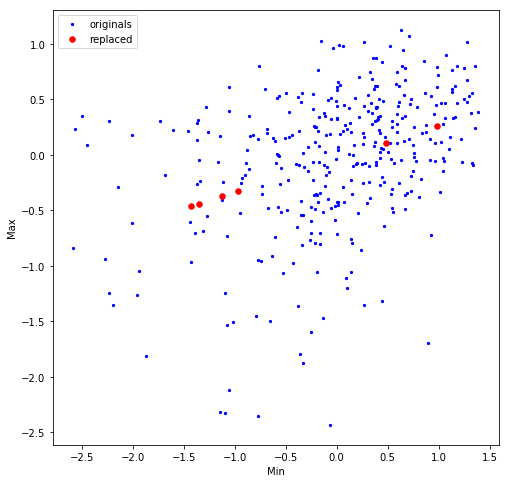

In [218]:
plt.figure(figsize=(8,8))
plt.scatter(df['Min_Treating_Pressure (KPa)'][~MaxNotMin],df['Max_Treating_pressure (KPa)'][~MaxNotMin],color='blue',s=5,label='originals')
plt.scatter(df['Min_Treating_Pressure (KPa)'][MaxNotMin],df['Max_Treating_pressure (KPa)'][MaxNotMin],color='red',s=30,label='replaced')
plt.ylabel('Max')
plt.xlabel('Min')
plt.legend()

In [220]:
a3=lin_regr('Avg_Treating_Pressure (KPa)','Max_Treating_pressure (KPa)')
rows=df[MaxNotAv].index
df.loc[rows,'Max_Treating_pressure (KPa)']=(df['Avg_Treating_Pressure (KPa)'][MaxNotAv]- mMa)*a3+ mMa
#df.loc[rows,'Max_Treating_pressure (KPa)']
#df.loc[rows,'API']

we estimate y= ax+b, with a equals:[ 0.46717446]


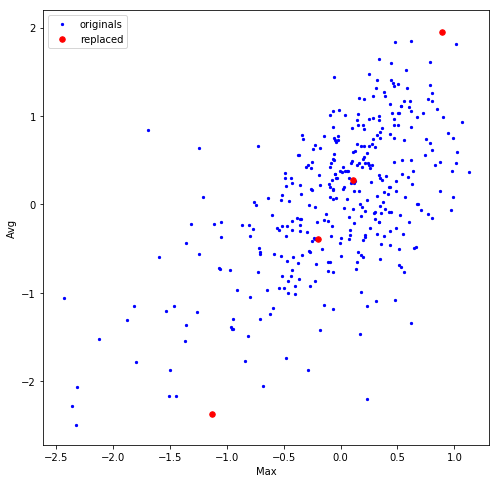

In [222]:
plt.figure(figsize=(8,8))
plt.scatter(df['Max_Treating_pressure (KPa)'][~MaxNotAv],df['Avg_Treating_Pressure (KPa)'][~MaxNotAv],color='blue',s=5,label='originals')
plt.scatter(df['Max_Treating_pressure (KPa)'][MaxNotAv],df['Avg_Treating_Pressure (KPa)'][MaxNotAv],color='red',s=30,label='replaced')
plt.ylabel('Avg')
plt.xlabel('Max')
plt.legend()

In [223]:
missing_Atp=np.isnan(df["Avg_Treating_Pressure (KPa)"])
missing_Mitp=np.isnan(df["Min_Treating_Pressure (KPa)"])
missing_Matp=np.isnan(df["Max_Treating_pressure (KPa)"])
print(sum(missing_Atp))
print(sum(missing_Mitp))
print(sum(missing_Matp))


0
0
0


we have no more missing values.

++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++

For the following features, we will only check the outliers. Imputation of missing values is done in another script ( Toufik or Youssef)
## Nbr_Stages no serious outliers

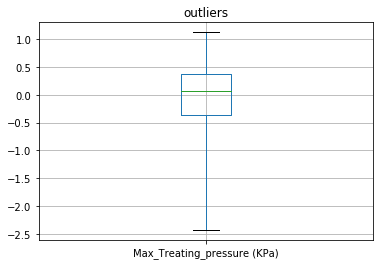

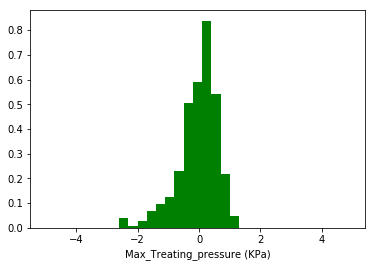

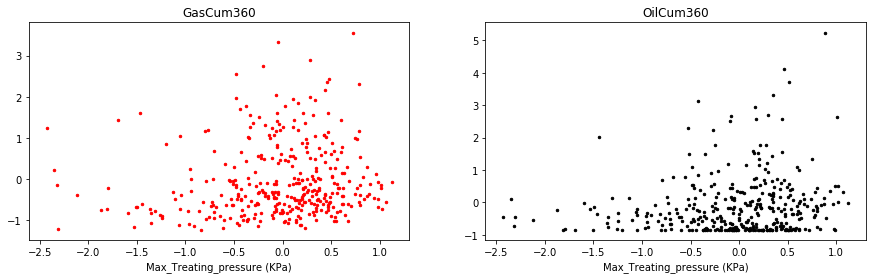

In [230]:
outst_Matp=vis_and_return_Outl(df,'Max_Treating_pressure (KPa)',3,delta=0.3,a=-5,b=5)

## Frac_Gradient (PSI/ft
one outlier

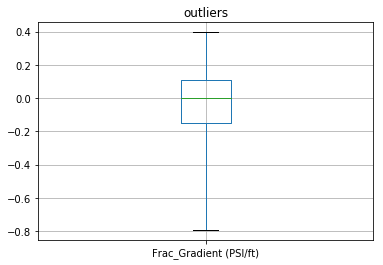

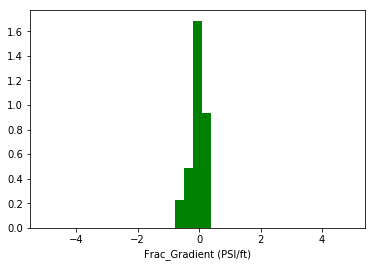

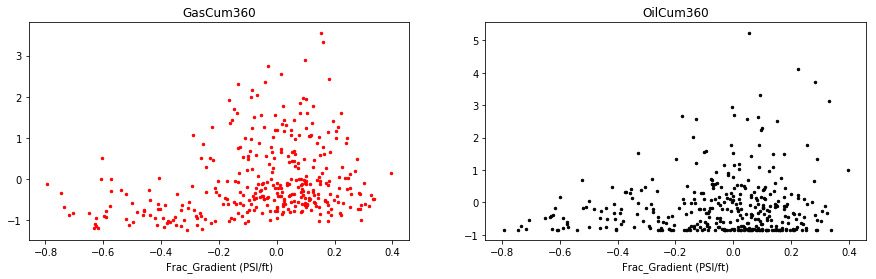

In [231]:
outsf_=vis_and_return_Outl(df,'Frac_Gradient (PSI/ft)',3,delta=0.3,a=-5,b=5)
rows=df[df['Frac_Gradient (PSI/ft)']>0.4].index
df.loc[rows,'Frac_Gradient (PSI/ft)']=0

In [232]:
#vis_and_return_Outl(df,'Frac_Gradient (PSI/ft)',3,delta=0.3,a=-5,b=5)

## Proppant_Designed (kg)


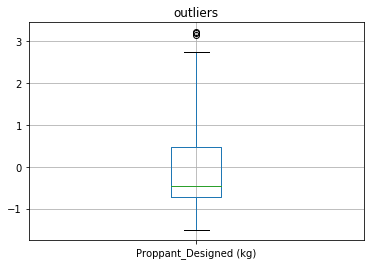

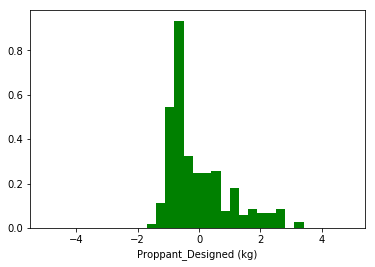

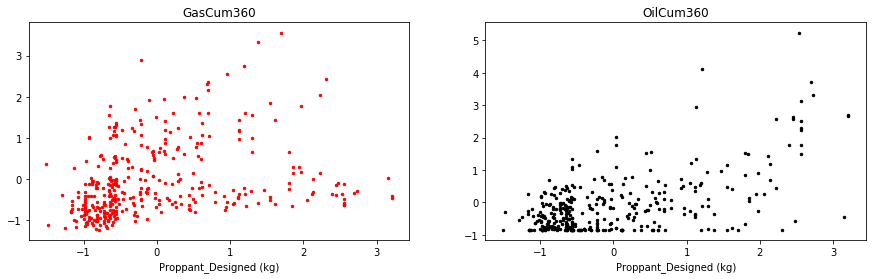

In [233]:
outs_prop=vis_and_return_Outl(df,'Proppant_Designed (kg)',2,delta=0.3,a=-5,b=5)

In [234]:
rows=outs_prop.index
df.loc[rows,'Proppant_Designed (kg)']=0

## Proppant_in_Formation (kg)


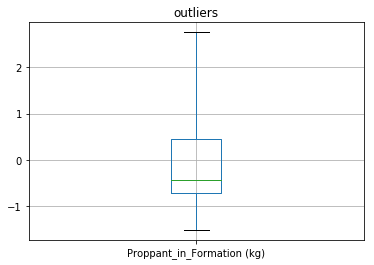

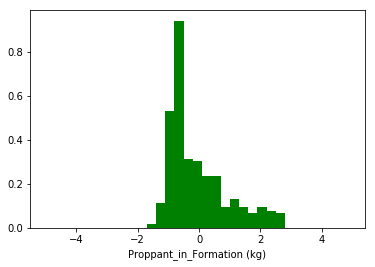

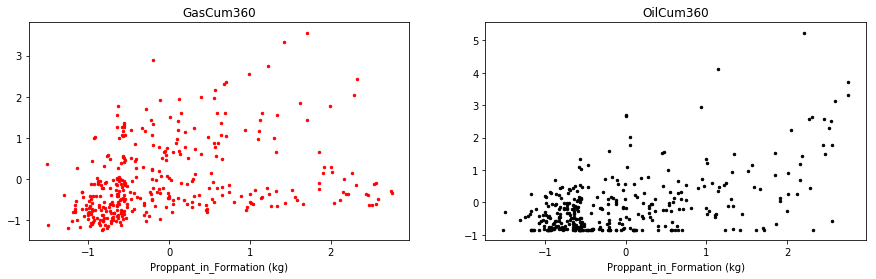

In [235]:
outs_prop2=vis_and_return_Outl(df,'Proppant_in_Formation (kg)',2,delta=0.3,a=-5,b=5)
rows=outs_prop2.index
df.loc[rows,'Proppant_in_Formation (kg)']=0

## Avg_Rate_Slurry (bpm)



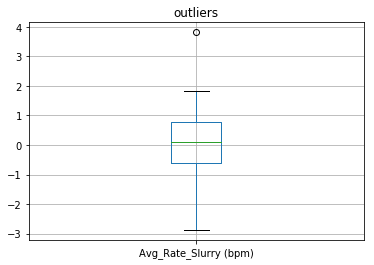

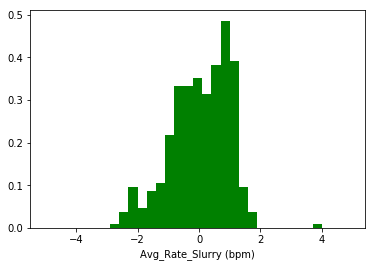

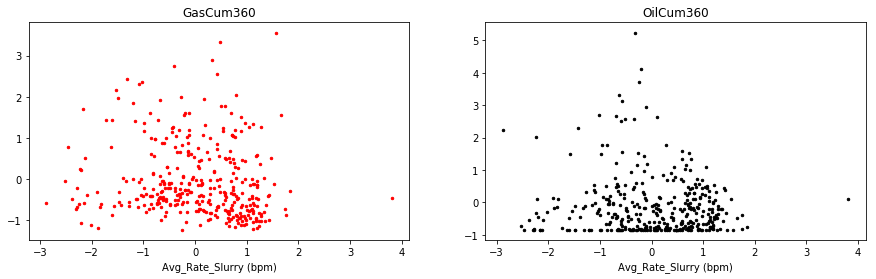

In [236]:
outs_sl=vis_and_return_Outl(df,'Avg_Rate_Slurry (bpm)',2,delta=0.3,a=-5,b=5)

In [237]:
rows=outs_sl.index
df.loc[rows,'Avg_Rate_Slurry (bpm)']=0

## Max_Rate_Slurry (bpm)


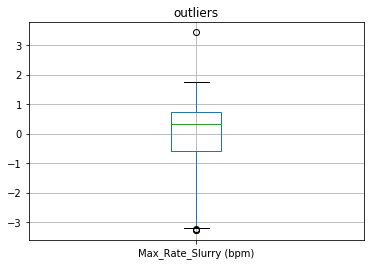

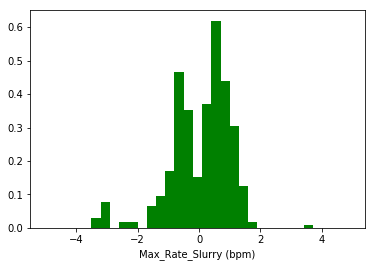

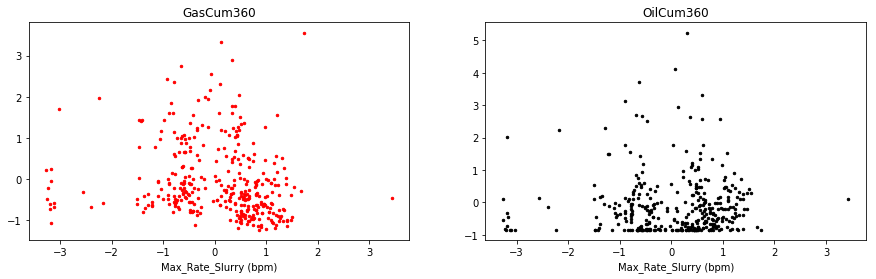

In [238]:
outs_slma=vis_and_return_Outl(df,'Max_Rate_Slurry (bpm)',2,delta=0.3,a=-5,b=5)

In [239]:
rows=outs_slma.index
df.loc[rows,'Max_Rate_Slurry (bpm)']=0

## Min_Rate_Slurry (bpm)

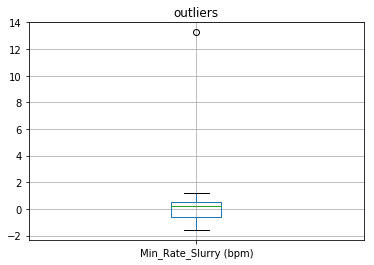

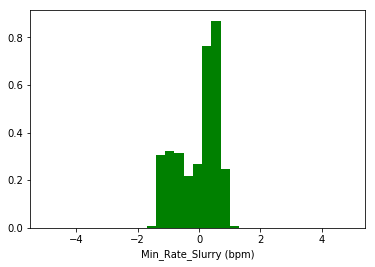

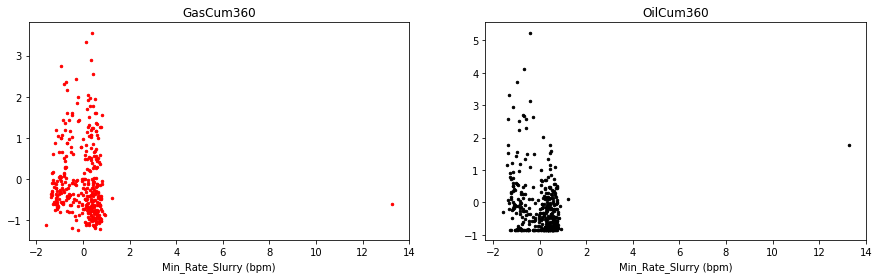

In [240]:
outs_slmin=vis_and_return_Outl(df,'Min_Rate_Slurry (bpm)',2,delta=0.3,a=-5,b=5)

In [241]:
rows=outs_slmin.index
df.loc[rows,'Min_Rate_Slurry (bpm)']=0

### Write everything to csv


In [242]:
df.to_csv('clean_final.csv',sep=',',na_rep='na')